In [563]:
# this cell contains dependencies for this notebook
import math
import numpy as nm
import matplotlib.pyplot as plt
import pylab
import matplotlib
import mpmath as mp

mp.dps = 500 # sets parameters for use of mpmath package

In [564]:
tp=0. # time of ponding, set to 0 by default, but the user 
      # can input a different constant value, and solutions 
      # will remain valid

# the following functions are the analytical equations 
# used by the next block to solve 

# all symbols are explicated in the table in the README document

# Domain 1 equations:
def h1(x0,x): # equation for average depth
    if a>=0:
        return((r*(1-nm.exp(a*(x0-x)))/(a*alpha))**(1./m))
    else:
        return((r*(nm.exp((-a)*(x-x0))-1)/((-a)*alpha))**(1./m))
def t1(h): # equation for time characteristic
    return(tp+h/(r)*mp.hyp2f1(1.,1./m,1.+1./m,a*alpha*h**m/(r)) )
def hstar1(tvals,hvals): # routine to estimate hstar in domain 1
    for i in range(len(tvals)): # for loop finds the index of the first time after tr
        endval = 0
        if tvals[i]>tr and enval==0:
            endval = i
    slopeval = (hvals[endval]-hvals[endval-1])/(tvals[endval]-tvals[endval-1]) # slope of line between hvals and tvals straddling tr
    constval = hvals[endval]-tvals[endval]*slopeval # constant for line between hvals and tvals straddling tr
    return(tr*slopeval+constval)
def xstar1(x0,hstar): # equation for location at tr
    if a>=0:
        return(x0+a**(-1.)*nm.log((r)/(r-a*alpha*hstar**(m))))
    else:
        return(x0+(-a)**(-1.)*(nm.log((r+(-a)*alpha*hstar**(m)))-nm.log(r)))

# Domain 2 equations:    
def h2(t0,x,xtop): # equation for average depth
    return(h1(xtop,x))
def t2(t0,x): # equation for time characteristic
    return(t0+t1(h2(t0,x,xtop)))
def hstar2(tvals,hvals): # routine to estimate hstar in domain 2
    for i in range(len(tvals)): # for loop finds the index of the first time after tr
        endval = 0
        if tvals[i]>tr and enval==0:
            endval = i
    slopeval = (hvals[endval]-hvals[endval-1])/(tvals[endval]-tvals[endval-1]) # slope of line between hvals and tvals straddling tr
    constval = hvals[endval]-tvals[endval]*slopeval # constant for line between hvals and tvals straddling tr
    return(tr*slopeval+constval)
def xstar2(t0,xtop,hstar): # equation for location at tr
    if a>=0:
        return(xtop+(a**(-1.))*nm.log((r)/(r-a*alpha*hstar**(m))))
    else:
        return(xtop+(-a)**(-1.)*nm.log((r+(-a)*alpha*hstar**(m))/(r)))

# Domain 3 equations:   
def h3(xstar,x,hstar): # equation for average depth
    return(hstar*nm.exp(-a/m*(x-xstar)))
def t3(xstar,x,hstar): # equation for time characteristic
    return(tr+1./(alpha*a*(m-1.))*(1./h3(xstar,x,hstar)**(m-1.)-1./hstar**(m-1.)))

a =  1e-11
hillslope dimensions:  0.0 ,  50.0


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


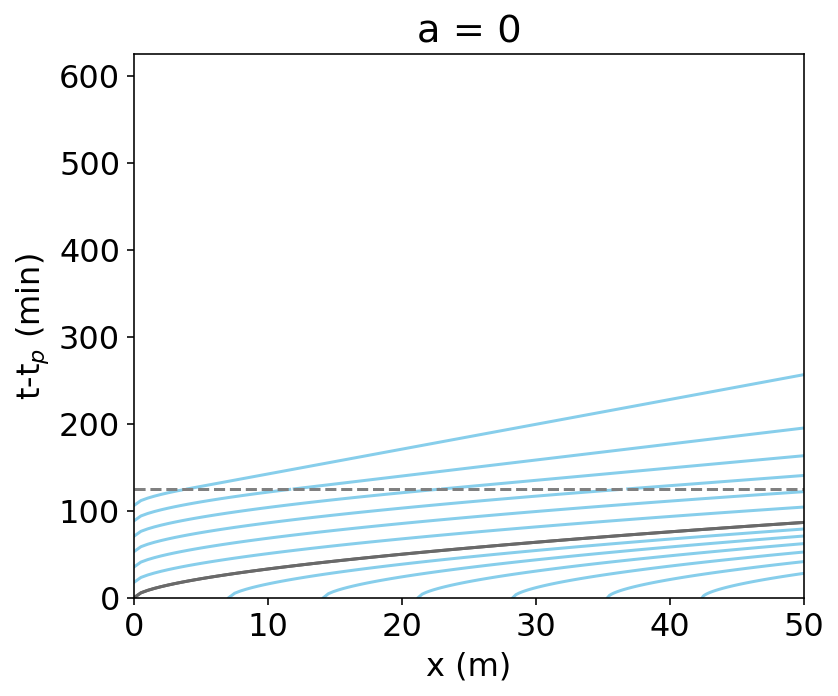

a =  -0.0001
hillslope dimensions:  0.0 ,  50.0


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in log


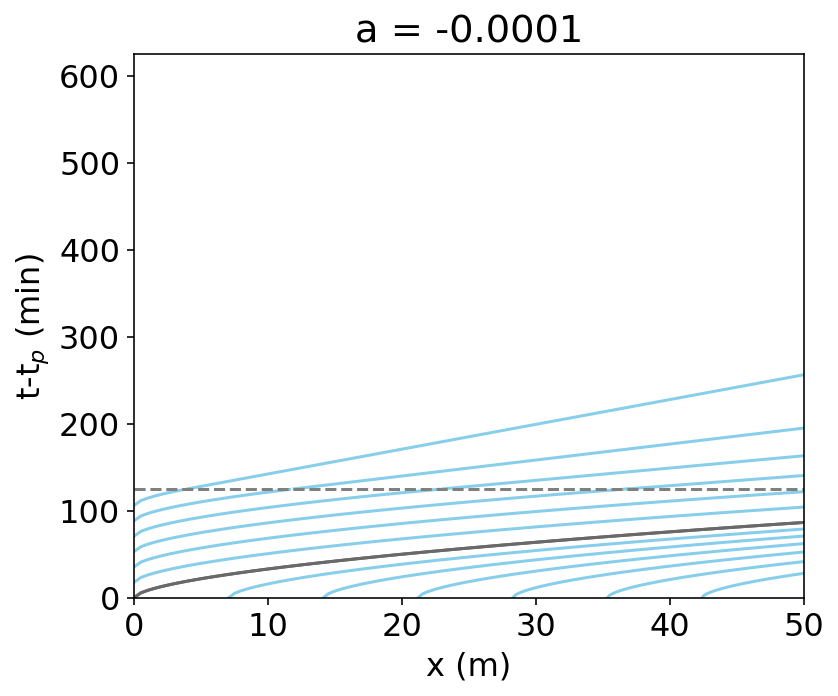

a =  0.0001
hillslope dimensions:  0.0 ,  50.0


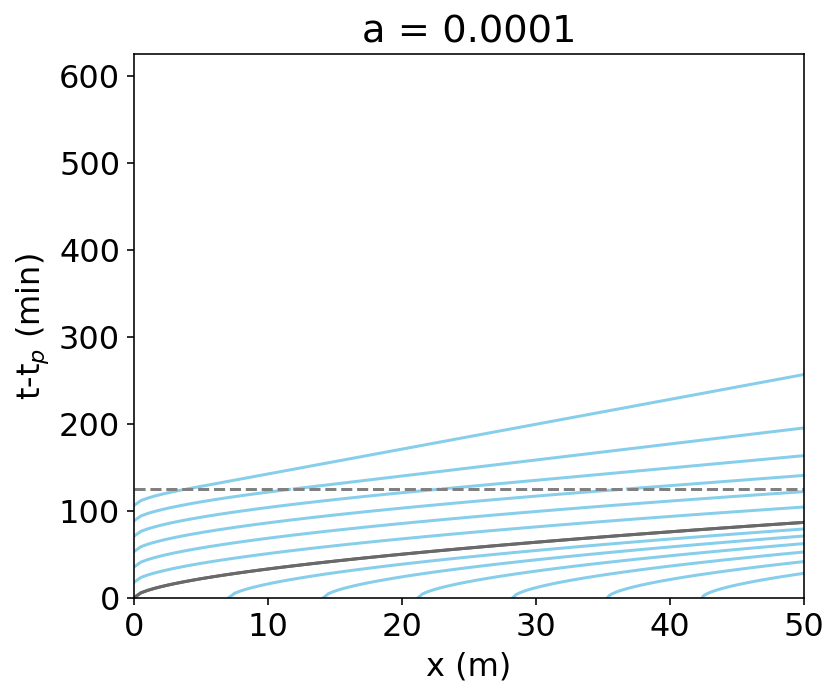

In [609]:
# this block solves for the hydrograph based on user parameters and displays
# the characteristic net for user-defined problems

matplotlib.rcParams.update({'font.size': 16}) # sets the font size for characteristics figures
%config InlineBackend.figure_format = 'retina' # sets the image resolution to retina quality


# User-defined constants and values

r=50./100./3600.          # rainfall rate in m/s
tr=125.*60                # end of rainstorm in seconds
alpha=0.012            # coefficient alpha=(So)^(1/2)/n
m=5./3.                  # value of m

color1='skyblue'         # color for plotting characteristics
colorbold='dimgrey'      # color for limiting characteristic

alist= ['0', '-0.0001', '0.0001']      # list of strings for the values of a to solve, can set up to 6 without breaking anything

different = False         # parameter that tells the program to use hillslopeSizeDict if True. If False, program will use user-set xend and xtop for all cases
hillslopeSizeDict = {'0':[0,50], '-0.0001':[0,50], '0.0001':[0,50] }  # dictionary holding values of: [location of divide, location of outlet]
xend = 50.               # location of stream outlet
xtop = 0.                # location of divide

# dictionaries holding solution information
touts_tot={aval:[] for aval in alist} # a list of time values at which depth is collected for each value of a
houts_tot={aval:[] for aval in alist} # a list of depths corresponding to the time values collected for each value of a

#solution begins below
for aval in alist:                           # for loop that completes solution for each user-specified value of a
    plt.figure(figsize=(6,5))                # sets image size for figures
    if aval == '0':
        a=0.00000000001                      # a cannot be 0, so we set it to a very small number instead
    else:
        a=float(aval)                        # sets value of a for following simulation
    if different == True:                    # sets locations of divide and outlet based on hillslopeSizeDict if True or xend and xtop if False
        xend=hillslopeSizeDict[aval][1]
        xtop=hillslopeSizeDict[aval][0]
    print 'a = ',a                           # prints value of a for simulation
    xstarvals = []                           # list of characteristic locations at tr
    hstarvals = []                           # list of depths associated with characteristic locations at tr
    houts1 = []                              # list of depths at outlet from domain 1
    touts1 = []                              # list of times associated with outlet depths from domain 1
    houts2 = []                              # list of depths at outlet from domain 2
    touts2 = []                              # list of times associated with outlet depths from domain 2
    houts3 = []                              # list of depths at outlet from domain 3
    touts3 = []                              # list of times associated with outlet depths from domain 3
    xstarplot = []                           # list of xstar vals used to plot characteristics starting at t=tr
    
    print 'hillslope dimensions: ',xtop, ', ',xend  # prints dimensions of the hillslope
    
    # Solution for Domain 1
    
    x0vals = nm.linspace(xtop,xend,100)             # initiate a list of 100 x0 values to start characteristics
    for val in x0vals:                              # for loop solves a characteristic for each x0
        xvals= nm.linspace(val,xend,100)           # initiates 1000 xvals to solve the characteristic on
        hvals= h1(val,xvals)                        # finds depth using domain 1 equation at each xval
        tvals= [float(mp.nstr(t1(hval))) for hval in hvals]                 # finds the associated time for each depth value
        
        d=len(tvals)                                
        for g in range (len(tvals)):    # loops through elements in tvals  
            if tvals[g]>tr:             # notes the latest time before tr as an index in the list
                if d==len(tvals):      
                    d=g-1
        for g in range(len(tvals)):     # for times after the characteristic reaches tr, we throw out the information 
            if g>d:
                tvals[g]=tvals[d]
                hvals[g]=hvals[d]
                xvals[g]=xvals[d]
        
        if t1(h1(val,xend))<tr:                 # if statement tests whether the characteristic crosses the outlet before tr
            houts1 = houts1+[h1(val,xend)]               # if so, then the depth and time of crossing are kept for the hydrograph
            touts1 = touts1+[t1(h1(val,xend))]
        else:
            hstarvals=hstarvals+[hstar1(tvals,hvals)]                   # if not, then the location xstar and depth hstar for this characteristic     
            xstarvals=xstarvals+[xstar1(val,hstar1(tvals,hvals))]       # are saved to send to domain 3
        
        # the following if statement plots the limiting characteristic in colorbold, the rest in color1
        if val==x0vals[0]:
            pylab.plot(xvals,[t/60 for t in tvals], c=colorbold)
            xstarplot = xstarplot+[xstar1(val,hstar1(tvals,hvals))]
        elif val in [x0vals[i*14] for i in list(range(7))]: # plot only a handful of the characterstics, not all of them
            pylab.plot(xvals,[t/60 for t in tvals],c=color1)
            xstarplot = xstarplot+[xstar1(val,hstar1(tvals,hvals))]
    
    touts1.reverse()                                     # reverses the elements of touts1 since they are backwards
    houts1.reverse()                                     # reverses the elements of houts1 to stay consistent with touts1
    
    # Solution for Domain 2
    
    t0vals = nm.linspace(0,tr,100)                       # initiates a set of t0vals to start characteristics in domain 2
    for val in t0vals:                                   # for loop solves a characteristic for each t0
        xvals = nm.linspace(xtop,xend,100)              # initiates a set of xvals to solve characteristic on
        hvals = h2(val,xvals,xtop)                       # finds depth along characteristic using domain 2 equation
        tvals = [float(mp.nstr(t2(val,xval))) for xval in xvals]                           # solves for t(x) characteristic using domain 2 equation
        
        d=len(tvals)
        for g in range(len(tvals)):         # loops through elements in tvals
            if tvals[g]>tr:                 # notes the latest time before tr as an index in the list
                if d==len(tvals):
                    d=g-1
        for g in range(len(tvals)):         # throws out all information occuring after tr
            if g>d:
                tvals[g]=tvals[d]
                hvals[g]=hvals[d]
                xvals[g]=xvals[d]
        
        if t2(val,xend)<=tr:                          # if statement tests whether the characteristic crosses the outlet before tr
            houts2 = houts2+[h2(val,xend,xtop)]       # if so, then the depth and time of crossing are kept for the hydrograph
            touts2 = touts2+[t2(val,xend)]
        else:
            xstarvals=[xstar2(val,xtop,hstar2(tvals,hvals))]+xstarvals               # if not, then the location xstar and depth hstar for this characteristic
            hstarvals=[hstar2(tvals,hvals)]+hstarvals  # are saved to send to domain 3
        
        # the following if statement plots the limiting characteristic in colorbold, the rest in color1
        if val==t0vals[0]:
            pylab.plot(xvals,[t/60 for t in tvals],c=colorbold)
            xstarplot = xstarplot+[xstar2(val,xtop,hstar2(tvals,hvals))]
        elif val in [t0vals[i*14] for i in list(range(7))]: # plot only a handful of the characteristics, not all of them
            pylab.plot(xvals,[t/60 for t in tvals],c=color1)
            xstarplot = xstarplot+[xstar2(val,xtop,hstar2(tvals,hvals))]

    # Solution for Domain 3:        
    
    for i in range (len(xstarvals)):                       # for loop solves characteristic for each xstarval
        xvals = nm.linspace(xstarvals[i],xend,10)        # initiates set of xvals to solve the characteristic on
        hvals = h3(xstarvals[i],xvals,hstarvals[i])        # solves for depths along characteristic using domain 3 equation
        tvals = t3(xstarvals[i],xvals,hstarvals[i])        # solves for t(x) characteristic using domain 3 equation
        
        d=len(tvals)
        for g in range(len(xvals)):                                     # loops through xvals
            if math.isnan(hvals[g]):                                    # checks if an xval is NaN
                if d==len(tvals):                                       # marks the beginning of NaN values, since all following values will be Nan
                    d=g
        for g in range(len(tvals)):          # loops through tvals throwing out NaN data or data after characteristic disappears
            if g>d:
                tvals[g]=tvals[d]
                hvals[g]=hvals[d]
                xvals[g]=xvals[d]
                
        if f==0:                                                 # if f=0, then all characteristics eventually leave landscape, so...
            houts3 = houts3+[h3(xstarvals[i],xend,hstarvals[i])]     # tracks the depth when each characteristic leaves the landscape
            touts3 = touts3+[t3(xstarvals[i],xend,hstarvals[i])]     # tracks the time each characteristic leaves the landscape
        if xzw(xstarvals[i],hstarvals[i])>=xend:                 # if f!=0, then not all characteristics leave landscape. If they leave, then
            houts3 = houts3+[h3(xstarvals[i],xend,hstarvals[i])]     # tracks depth
            touts3 = touts3+[t3(xstarvals[i],xend,hstarvals[i])]     # and time when they leave
        if xvals[0] in xstarplot:                                # we initiated many more characteristics than we plot, so 
            pylab.plot(xvals,[t/60 for t in tvals],c=color1)     # plot only the continuation of characteristics already on the plot

    houts3.reverse()           # reverse houts3 since it is backwards
    touts3.reverse()           # reverse touts3 since it is backwards


    houts=houts1+houts2+houts3    # aggregate all depth data at outlet into one list
    touts=touts1+touts2+touts3    # aggregate all time data at outlet into one list
    
    houts_tot[aval]=houts         # save depth data to the dictionary houts_tot
    touts_tot[aval]=touts         # save time data to the dictionary touts_tot
    
    
    plt.plot([0,xend],[tr/60,tr/60],c='gray',linestyle='--')          # plots a horizontal line at t=tr
    plt.xlim(0,xend)             # sets x-axis to show only the hillslope
    plt.ylim(0,5*tr/60)          # sets y-axis to display a period 5 times the rainstorm length
    plt.xlabel('x (m)')          # x-axis label
    plt.ylabel('t-t$_p$ (min)')  # y-axis label
    plt.title('a = ' + aval)     # plot title
    plt.show()                   # makes each plot display separately


('-0.0001', 'teq = ', mpf('86.395698570108067'), ' qmax = ', 15.037562578202875)
('0', 'teq = ', mpf('86.42811175158208'), ' qmax = ', 15.000001241105565)
('0.0001', 'teq = ', mpf('86.460519643490272'), ' qmax = ', 14.962562421953042)


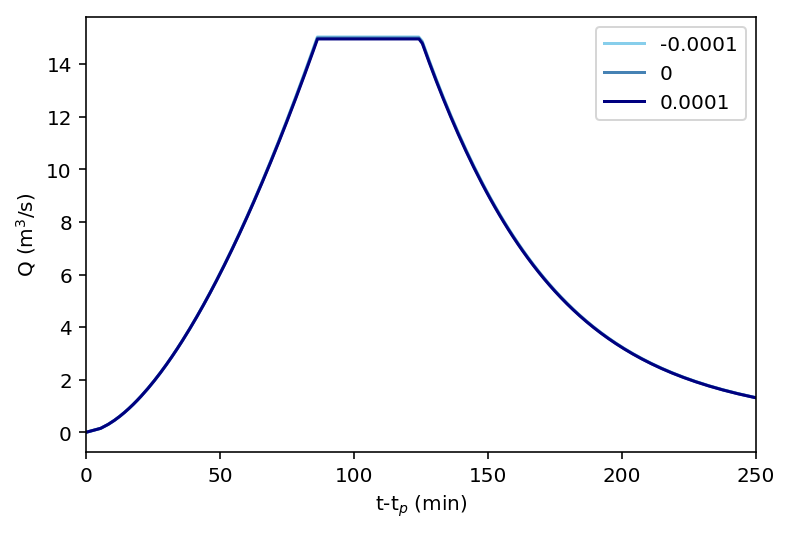

In [614]:
# this block plots hydrographs from the solutions found above

# User-defined parameters

showq = False    # you can choose to plot q or Q, not both. Set the appropriate value to True.
showQ = True

outlet_width = {'0':60, '-0.0001':60, '0.0001':60}  # dictionary of outlet widths. optional to use. To set
                                                          # all outlet widths to the same value, ignore this and set
                                                          # outletSame = True
outletSame = False                                        # key that tells the program whether you want the outlet widths
                                                          # set individually by outlet_width or the same for all set by
                                                          # the number outlet
outlet = 1.                                               # if using outlet_width, the value of outlet does not matter

matplotlib.rcParams.update({'font.size': 10})             # sets font size for figure
plotnames=['e','b','d','f','g','i']                       # list of plotname keys, can plot up to 6 hydrographs together
maxq={aval:0 for aval in touts_tot.                       # dictionary of maximum flow values
      keys()}

j=0
colorlist=['skyblue','steelblue','navy','k','b','c']      # list of plotting colors
%config InlineBackend.figure_format = 'retina'            # makes figure retina quality

# plot hydrographs

keylist = alist 
keylist.sort()             # sorts the list of avals in keylist



for aval in keylist:                      # plots a hydrograph for each value of a
    if different==True:                   # defines hillslope dimension in x using hillslopeSizeDict if true or xend and xtop if False
        xend=hillslopeSizeDict[aval][1]
        xtop=hillslopeSizeDict[aval][0]
    if outletSame == False:               # defines outlet width using outlet_width if False or outlet if True
        outlet = outlet_width[aval]
        
    qouts=[]    # list of q values for hydrograph
    Qouts=[]    # list of Q values for hydrograph
    
    for i in range(len(houts_tot[aval])):                      # loops through houts_tot[aval], the depth values saved from above
        Qouts= Qouts+[(alpha*(houts_tot[aval][i])**m*outlet*3600/100)]  # produces Q valuse at each time
        qouts= qouts+[(alpha*(houts_tot[aval][i])**m)]         # produces q values at each time
    
    if showq==True:                   # saves maximum flow value for q or Q depending on user preference
        maxq[aval]=max(qouts)
    elif showQ==True:
        maxq[aval]=max(Qouts)  

    
    tmin=[]  # list of time values in minutes for hydrograph
    
    for val in touts_tot[aval]:      # converts time values to minutes and saves in tmin
        tmin=tmin+[float(val)/60.]
    
    qoutsmmhr = []      # q values in mm/hr
    Qoutsmmhr = []      # Q values in mm2/hr
    
    for val in qouts:  # converts q and Q to mm(2)/hr units
        qoutsmmhr=qoutsmmhr+[(val*3600/100)]
        Qoutsmmhr=Qoutsmmhr+[(val*3600/100)*outlet]
    
    # plot q or Q, depending on user preference
    if showq == True:
        plotnames[j]=pylab.plot((tmin),(qoutsmmhr),colorlist[j])
    elif showQ == True:
        plotnames[j]=pylab.plot((tmin),(Qoutsmmhr),colorlist[j])
    
    # searches for tc by finding the first time that the maximum value is hit since the max case is the equilibrium case
    k=0
    for i in range(len(qouts)):
        if maxq[aval]==qouts[i] and k==0:
            k=i
        elif maxq[aval]==Qouts[i] and k==0:
            k=i
            
    # prints out the value of a, teq, and qmax
    print(aval, 'teq = ',touts_tot[aval][k]/60, ' qmax = ',maxq[aval])
    
    # increases the value of j, which is used for plotting labels
    j+=1

# this if/else plots q or Q, depending on user preference above
if showq ==True:
    plt.ylabel('q (m$^2$/s)') 
elif showQ == True:
    plt.ylabel('Q (m$^3$/s)')
    
plt.xlim(0,250)                             # sets plot limit to 5 times storm lenth
plt.xlabel('t-t$_p$ (min)')                     # x-axis label
plt.legend(plotnames,labels=keylist,loc='best') # adds a legend to the plot


plt.show()                                      # displays the plot
